In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import jax.numpy as jnp
from tinyjaxley.modules.comp import Compartment
from tinyjaxley.modules.branch import Branch
# from tinyjaxley.modules.cell import Cell
from tinyjaxley.channels.hh import Na, K, Leak
import matplotlib.pyplot as plt
from tinyjaxley.solvers import fw_euler
import pandas as pd
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5

- recurse into channels -> set and get should work for example
    - submodules should get custom method for each module, i.e. comp.channels -> comp.submodules, branch.comps -> branch.submodules, etc.
- fix `comp.set(("k", "n"), 0.0)` same for `clamp` and `record`
- tests to assert against jaxley

In [77]:
comp = Compartment()
# comp.record("v")
comp.insert(Leak())
comp.insert(Na())
comp.insert(K())
# comp.stimulate(lambda t, u, p: 0.01)

t0 = 0
p = comp.params
u0 = comp.states
# comp.set("v", -70.0)
# u0 = comp.init(t0, comp.states, comp.params)

In [78]:
# def find_nodes_by_ref(root, ref_path, depth=0):
#     ref_path = ref_path if isinstance(ref_path, tuple) else (ref_path,)
#     if depth >= len(ref_path): return []
#     if root.key != ref_path[depth]: return []
    
#     matches = [root] if depth == len(ref_path) - 1 else []
#     if not root.is_leaf():
#         for child in root.children:
#             matches.extend(find_nodes_by_ref(child, ref_path, depth + 1))
#     return matches

# ref = ("branch","comp", "leak")

# find_nodes_by_ref(branch, ref)

In [75]:
ode = ODETerm(comp.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

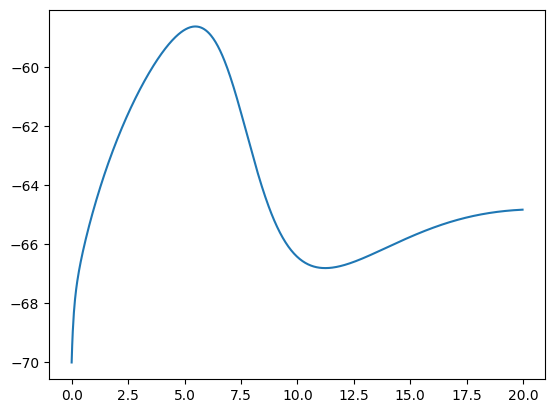

In [76]:
plt.plot(sol.ts, sol.ys[0]["v"])

In [20]:
branch = Branch([Compartment()]*100)
branch.record("v")
branch.add(Leak())
branch.add(Na())
branch.add(K())
branch.comp(0).stimulate(lambda t, u, p: 0.05)
branch.comp(1).stimulate(lambda t, u, p: -0.05)

t0 = 0
p = branch.params
u0 = branch.init(t0, branch.states, branch.params)
branch.set("v", -70.0)

In [21]:
ode = ODETerm(branch.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

KeyboardInterrupt: 